# 1. Preparing the environment

In [2]:
import pandas as pd
dfdata = pd.read_csv('D:\DATA ANALYSIS\Final_proj\Goblo.csv')
dfdata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48943 entries, 0 to 48942
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  48943 non-null  int64  
 1   id          48943 non-null  int64  
 2   country     48943 non-null  object 
 3   gender      48943 non-null  object 
 4   group_name  48943 non-null  object 
 5   join_dt     48943 non-null  object 
 6   device      48943 non-null  object 
 7   count       48943 non-null  float64
 8   sum         48943 non-null  float64
 9   converted   48943 non-null  int64  
 10  days_diff   48943 non-null  float64
 11  novelty     48943 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.5+ MB


## Importing packages

In [3]:
##     Import statistics packages

import numpy as np
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

##     This line alows plots to be displayed in the notebook
%matplotlib inline
# Some plot styling preferences
plt.style.use('seaborn-whitegrid')

##     This lines modify the default matplotlib fonts through all the notebook
font = {'weight' : 'bold',
'size' : 14}
mpl.rc('font', **font)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12708\2079263886.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# 2. Preparing the data

# 3. Preparing the test

## Calculating sample size

In [11]:
## Thisi is the expected diference we'll find between groups

effect_size = sms.proportion_effectsize(0.1,0.2)
effect_size

-0.2837941092083278

In [7]:
## Calculating the sample size

required_n=sms.NormalIndPower().solve_power(
effect_size,
power=0.8,
alpha=0.05,
ratio=1)
required_n = int(required_n)
required_n

1483

## Knowing sample size, prepare the db abtest

In [8]:
## Now we create our control and treatment groups

ctrl_smpl = dfdata[dfdata['group_name'] == 'A']
trtm_smpl = dfdata[dfdata['group_name'] == 'B']

## We join both tables to perform the AB test

abtest = pd.concat([ctrl_smpl,trtm_smpl],axis = 0) ## Axis 0 is rows, axis 1 columns

## Now we drop the index. Is it really necessary??
abtest.reset_index(drop=True, inplace=True)


In [9]:
abtest['group_name'].value_counts()

group_name
B    24600
A    24343
Name: count, dtype: int64

In [10]:
abtest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48943 entries, 0 to 48942
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  48943 non-null  int64  
 1   id          48943 non-null  int64  
 2   country     48943 non-null  object 
 3   gender      48943 non-null  object 
 4   group_name  48943 non-null  object 
 5   join_dt     48943 non-null  object 
 6   device      48943 non-null  object 
 7   count       48943 non-null  float64
 8   sum         48943 non-null  float64
 9   converted   48943 non-null  int64  
 10  days_diff   48943 non-null  float64
 11  novelty     48943 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.5+ MB


# 4. Performing test for conversion rate

## 4.1 Knowing the metrics

In [8]:
converted_rate = abtest.groupby('group_name')['converted']

std_p = lambda x: np.std(x,ddof=0)
se_p = lambda x: stats.sem(x,ddof=0)

##converted_rate = converted_rate.agg([np.mean,np.std('converted',ddof=0),stats.sem('converted',ddof=0)])
converted_rate = converted_rate.agg([np.mean,std_p,se_p])
converted_rate.columns = (['mean', 'std_dev','std_err'])
converted_rate

,mean,std_dev,std_err
group_name,,,
A,0.039231,0.194144,0.001244
B,0.046301,0.210136,0.001340


## 4.2 Visualization

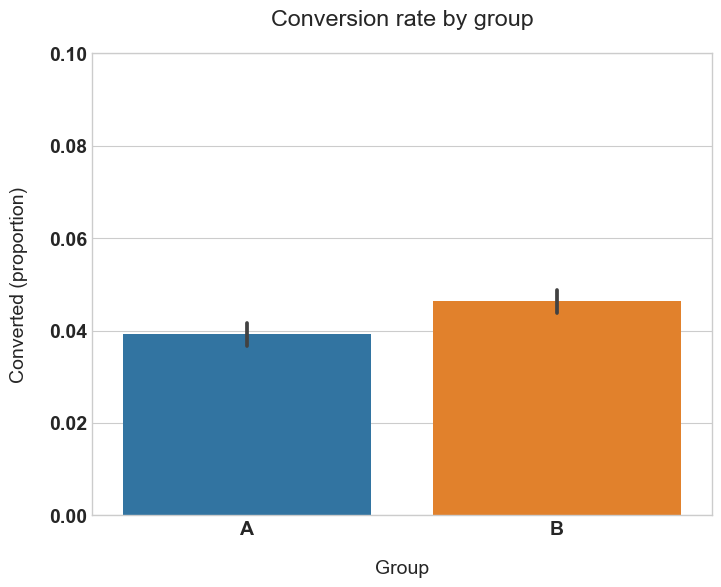

In [9]:
plt.figure(figsize=(8,6))
sns.barplot(x=abtest['group_name'], y=abtest['converted'])
plt.ylim(0, 0.10)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);


### 4.3 Performing test

In [10]:
from statsmodels.stats.proportion import proportions_ztest,proportion_confint

control_results = abtest[abtest['group_name'] == 'A']['converted']
treatment_results = abtest[abtest['group_name'] == 'B']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]


# Calculate z-statistic and p-value
z_stat, pval = proportions_ztest(successes, nobs=nobs)

# Calculate confidence intervals
(conf_lower_con, conf_upper_con), (conf_lower_treat, conf_upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)


print(f'z statistic: {z_stat:.4f}')
print(f'p-value: {pval:.9f}')
print(f'ci 95% for control group: [{conf_lower_con:.3f}, {conf_upper_con:.3f}]')
print(f'ci 95% for treatment group: [{conf_lower_treat:.5f},{conf_upper_treat:.5f}]')

z statistic: -3.8643
p-value: 0.000111412
ci 95% for control group: [0.037, 0.044]
ci 95% for treatment group: [0.04167,0.04893]


### 4.4 Results

Based on the results, with a p-value of 0.660 we can not confidently reject the null hypotesis. This is, there seems to be no difference between both groups.
This conclussion is contrasted by the fact that interval of confidence between both groups don't overlap. This means the with 95% confidence, the expected values of both groups won't be in the same interval.

## 5. performing test for Avg spent

In [11]:
### 5.1 Knowing the metrics

In [12]:
# Define custom aggregation functions
custom_mean = lambda x: np.mean(x)
custom_std = lambda x: np.std(x, ddof=0)
custom_se = lambda x: stats.sem(x, ddof=0)

# Group by 'group_name' and calculate the mean, standard deviation, and standard error of 'tot_spent' while considering zero values
grouped_data = abtest.groupby('group_name')['sum']
result = grouped_data.agg([custom_mean, custom_std, custom_se])
result.columns = (['mean', 'std_dev','std_err'])

result


,mean,std_dev,std_err
group_name,,,
A,3.374518,25.935858,0.166232
B,3.390867,25.413593,0.162031


### 4.2 Visualization

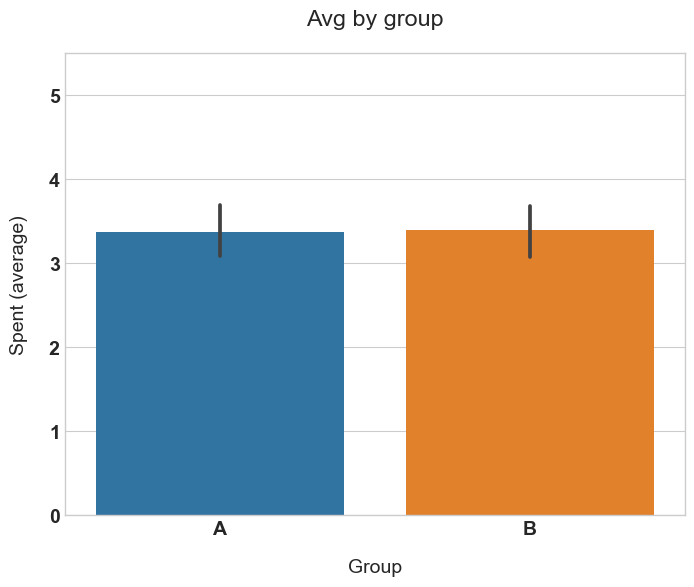

In [13]:
plt.figure(figsize=(8,6))
sns.barplot(x=abtest['group_name'], y=abtest['sum'])
plt.ylim(0, 5.5)
plt.title('Avg by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Spent (average)', labelpad=15);


## 5.3 Performing test

In [28]:
from statsmodels.stats.proportion import proportions_ztest,proportion_confint

control_grp = abtest[abtest['group_name'] == 'A']['sum']
test_grp =    abtest[abtest['group_name'] == 'B']['sum']


t_statistic, p_value = stats.ttest_ind(control_grp, test_grp)

# Calculate confidence interval
n1 = len(control_grp)
n2 = len(test_grp)
df = n1 + n2 - 2  # degrees of freedom
alpha = 0.05  # significance level
std_err = np.sqrt(np.var(control_grp) / n1 + np.var(test_grp) / n2)
crit_val = stats.t.ppf(1 - alpha / 2, df)
margin_error = stats.t.ppf(1 - alpha / 2, df) * std_err
mean_diff = np.mean(control_grp) - np.mean(test_grp)
confidence_interval = (mean_diff - margin_error, mean_diff + margin_error)

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)
print("Standard error:", std_err)
print("Critical value:", crit_val)
print("Margin Error:", margin_error)
print("Mean diff:", mean_diff)
print("Confidence Interval:", confidence_interval)

T-Statistic: -0.07043243221259018
P-Value: 0.9438497659375841
Standard error: 0.2321358148567269
Critical value: 1.9600124577813611
Margin Error: 0.45498908901641233
Mean diff: -0.01634847795798766
Confidence Interval: (-0.4713375669744, 0.43864061105842467)
